In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import math as m

## System description
Invision a system where a single aircraft (aircraft #1) is flying in a GPS-denied / degraded scenario, but it has a communication link to two other aircraft (aircraft #2 and #3).  These other aircraft are flying in a GPS-enabled scenario and the links to these aircraft also measure the range from aircraft 1 to aircraft 2 (and aircraft 3).  We would like to estimate the location of aircraft #1 over time.  Because aircraft #2 and #3 have GPS, we assume that their position estimates are always known and perfectly accurate.  

The goal of this project is to estimate the location of the aircraft #1 over time.  Its measurements are its local dynamics model and the two range measurements to moving, known positions.  A graph-based view of the states being estimated are below.

![LSO Graph](LSO_assign.png)

## Dynamics model
This code simulates an aircraft flying in (mostly) level flight.  We will be ignoring pitch and roll and modeling only yaw.  Therefore, the state vector for each aircraft will be:
$$\vec{x} = \begin{pmatrix}x\\y\\z\\ \psi\end{pmatrix}$$
and the dynamic model will be 
$$\dot{\vec{x}} = \begin{pmatrix}V \cos \psi \\ V \sin\psi \\-\kappa(z - h_t) \\ u\end{pmatrix} + w$$
where $V$ is the velocity of the aircraft, $u$ is the turn rate command (correlated with roll in fixed wing flight), and $\kappa$ is the gain parameter on a proportional controller keeping the aircraft at a target altitude ($h_t$).  The noise parameter $w$ is additive white Gaussian noise, with mean 0 and covariance $Q$.  Note that altitude will end up being a first-order Gauss-Markov random process, with its covariance defined by $Q$ and $\kappa$.

### Notes
All positions will be in the North-East-Down (NED) coordinate frame.

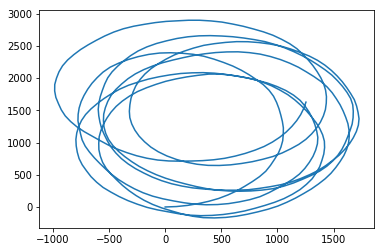

In [18]:
def boundAngle(input_angle: float):
    new_angle = input_angle
    if new_angle > m.pi:
        new_angle -= 2.0*m.pi
    if new_angle < -m.pi:
        new_angle += 2.0*m.pi
    return new_angle
    
def aircraftPositionSim(V: float, u: float, ht: float, Q: np.array, N: int, 
                        dt: float, init_x : np.array, ss_rate:int = 10, kappa = .1) -> np.array:
    # V, u, ht, and Q as defined in markdown above
    # N is how many timesteps you want
    # dt is how far apart each time step should be
    # init_x is the initial location of the aircraft
    # ss_rate is how many internal iterations it should do for each timestep
    going_out = np.zeros((4,N+1))
    going_out[:,0] = init_x
    curr_x = init_x.reshape(4,1)
    dt_i = dt/float(ss_rate) #internal_dt
    Q_i = Q / float(ss_rate) # internal_Q
    cholQ_i = la.cholesky(Q_i)
    for ii in range(1,N+1):
        next_x = curr_x.copy()
        for jj in range(ss_rate):
            next_x[0] += dt_i * V * m.cos(next_x[3])
            next_x[1] += dt_i * V * m.sin(next_x[3])
            next_x[2] += dt_i * kappa * (ht - next_x[2])
            next_x[3] += dt_i * u
            next_x += np.dot(cholQ_i,rand.normal(size=(4,1)))
            next_x[3] = boundAngle(next_x[3])
        curr_x = next_x
        going_out[:,ii] = next_x.reshape((4))
    return going_out

#Test if this works... u=5 degrees means 72 seconds to make a circle
to_plot = aircraftPositionSim(100,np.radians(5),10000, np.diag([.09, .09, 1, np.radians(.1)]),
                             500,1,np.array([0.,0.,10000.,0.]))
plt.plot(to_plot[0,:],to_plot[1,:])

## Measurement model

### Range measurements
The range measurement at each step assumes the position of Aircraft #2 (or #3) at time $j$ $(a2j_x, a2j_y, a2j_z)$ is known.  The measurement ($r$) is
$$ r = \sqrt{(a2j_x - xj_x)^2 + (a2j_y - xj_y)^2 + (a2j_z - xj_z)^2}$$

In [31]:
def rangeMeasure(ac1_loc, ac2_loc):
    return la.norm(ac2_loc-ac1_loc)

#simple tests
ac1_loc = np.array([0.,0.,0.])
ac2_loc = np.array([0.,0.,2.])
print ('2 meters apart, measurement is...',rangeMeasure(ac1_loc, ac2_loc))
ac2_loc = np.array([m.sqrt(1./3.), m.sqrt(1./3.), m.sqrt(1./3.)])
print ('1 meters apart, measurement is...',rangeMeasure(ac1_loc, ac2_loc))

2 meters apart, measurement is... 2.0
1 meters apart, measurement is... 1.0


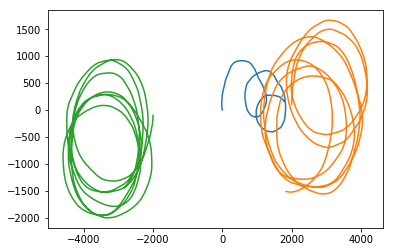

In [51]:
#Now let's create a system and its measurements.  Let's start with the parameters that define the system.
#system parameters
N = 1000
dt = .5
R_r = np.array([1]) #1m ranging error

#Known aircraft 2 parameters
ac2_start = np.array([100., 2000., -1000.,0.])
ac2_V = 100
ac2_u = np.radians(5)
ac2_ht = -900 + rand.uniform(200)
ac2_Q = np.diag([.09, .09, 1, np.radians(.1)])

#Known aircraft 3 parameters
ac3_start = np.array([-100., -2000., -1500., np.radians(180)])
ac3_V = 100
ac3_u = np.radians(5)
ac3_ht = -1600+rand.uniform(200)
ac3_Q = np.diag([.09, .09, 1, np.radians(.1)])

#aircraft1 parameters
ac1_start = np.array([0., 0., -100.,rand.uniform(0,2*m.pi)])
ac1_V = 15
ac1_u = np.radians(2)
ac1_ht = -100
ac1_Q = np.diag([.25, .25, 1, np.radians(.1)])

#Now make the flight patterns and measurements!
ac1_path = aircraftPositionSim(ac1_V, ac1_u, ac1_ht, ac1_Q, N, dt, ac1_start)
ac2_path = aircraftPositionSim(ac2_V, ac2_u, ac2_ht, ac2_Q, N, dt, ac2_start)
ac3_path = aircraftPositionSim(ac3_V, ac3_u, ac3_ht, ac3_Q, N, dt, ac3_start)
range_meas2 = np.zeros((N,1))
range_meas3 = np.zeros((N,1))
for i in range(N):
    range_meas2[i] = rangeMeasure(ac1_path[:,i],ac2_path[:,i]) + m.sqrt(R_r) * rand.normal()
    range_meas3[i] = rangeMeasure(ac1_path[:,i],ac3_path[:,i]) + m.sqrt(R_r) * rand.normal()

plt.plot(ac1_path[1,:],ac1_path[0,:])
plt.plot(ac2_path[1,:],ac2_path[0,:])
plt.plot(ac3_path[1,:],ac3_path[0,:])


# Assignment
## Primary assignment
Using the code above, you can generate a set of measurements.  Take these measurements and use a (weighted) Least Squared Optimization procedure to determine the estimated aircraft1 location over time.  Evaluate the accuracy of your technique in terms of aircraft1 location .

### Warning:
The heading direction of the aircraft is not strictly Euclidean.  The distance from $-\pi + \epsilon$ to $\pi - \epsilon$ is only $2\epsilon$ (very small).  However, if you treat it as a Euclidean space, you get $2\pi -2\epsilon$, which is relatively big.

## Analysis
Modify the R values to give different amount of noise to each measurements.  Which measurement has a larger effect on the overall error?  How accurate are your location estimates co